#Multiclass Classification

Make Blobs
* https://scikit-learn.org/stable/datasets/sample_generators.html#sample-generators
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs

In [3]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

## 1. Create multi-class data

1. Create some multi-class data with make_blobs().
2. Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
3. Split the data into training and test sets using train_test_split().
4. Visualize the data.

In [4]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X = torch.from_numpy(X_blob).type(torch.float)
y = torch.from_numpy(y_blob).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [5]:
X_train[:5], y_train[:5]

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         [-6.0262, -4.4375],
         [-3.3397,  7.2175]]),
 tensor([1., 0., 2., 2., 0.]))

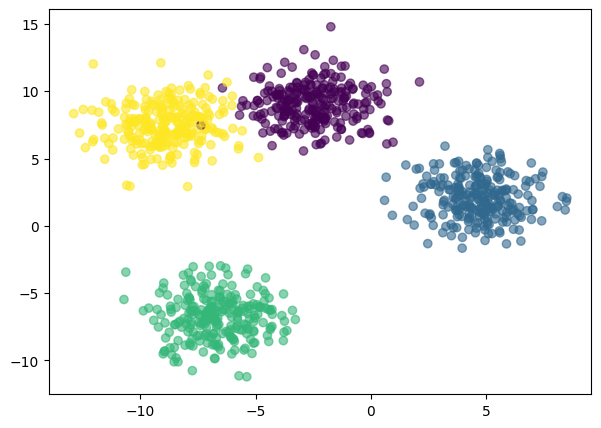

In [6]:
plt.figure(figsize=(7,5))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6)
plt.show()

## Build a multi-class classification model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=10):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [9]:
model = BlobModel(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=10
                 ).to(device)

## 3. Create a loss function and optimizer for a multi-class PyTorch model

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [12]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 4. Create a training and testing loop

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 150

# put data to the target device
X_train, y_train = X_train.to(device), y_train.type(torch.LongTensor).to(device)
X_test, y_test = X_test.to(device), y_test.type(torch.LongTensor).to(device)

for epoch in range(epochs):
  ### training
  model.train()

  y_logits = model(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 1.70219, Acc: 19.62% | Test Loss: 1.28434, Test Acc: 28.50%
Epoch: 10 | Loss: 0.57115, Acc: 91.50% | Test Loss: 0.46869, Test Acc: 90.50%
Epoch: 20 | Loss: 0.20072, Acc: 98.88% | Test Loss: 0.15614, Test Acc: 99.00%
Epoch: 30 | Loss: 0.09593, Acc: 99.50% | Test Loss: 0.07835, Test Acc: 99.50%
Epoch: 40 | Loss: 0.06542, Acc: 99.50% | Test Loss: 0.05290, Test Acc: 99.50%
Epoch: 50 | Loss: 0.05188, Acc: 99.50% | Test Loss: 0.04083, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04443, Acc: 99.50% | Test Loss: 0.03397, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03978, Acc: 99.50% | Test Loss: 0.02957, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03662, Acc: 99.38% | Test Loss: 0.02652, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03434, Acc: 99.38% | Test Loss: 0.02428, Test Acc: 99.50%
Epoch: 100 | Loss: 0.03263, Acc: 99.38% | Test Loss: 0.02256, Test Acc: 99.50%
Epoch: 110 | Loss: 0.03130, Acc: 99.38% | Test Loss: 0.02120, Test Acc: 99.50%
Epoch: 120 | Loss: 0.03025, Acc: 99.38% | Test Loss: 0.02009, T

### Evaluation metrics

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(y_test, test_pred)

0.995

In [22]:
confusion_matrix(y_test, test_pred)

array([[49,  0,  0,  0],
       [ 0, 41,  0,  0],
       [ 0,  0, 53,  0],
       [ 1,  0,  0, 56]])

In [26]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        53
           3       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200



In [29]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

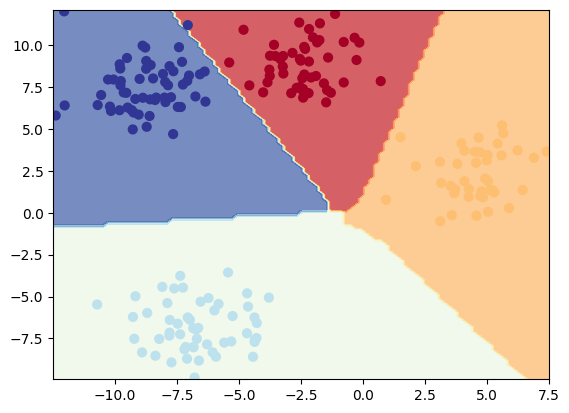

In [30]:
plot_decision_boundary(model, X_test, y_test)